# Logistic regression

Here is the plan for this notebook, with the main objective to practice logistic regression

* Generate a two dimensional data set with labels -1 and 1 using two gaussian random samples with different means (and perhaps also variances)

* Plot a visual sepator and calculate it's efficiency

* Implement a cross entropy loss function and its gradient with respect to parameters

* Implement a hinge loss function and its gradient with respect to parameters

* Implement a gradient descent algorithm that takes a function, its gradient, initial value and a step function

* Use the gradient descent algorithm to fit both the cross entropy and hinge loss models for various values of lambda and pick the best lambda. 

* Run cross validation on both models and compare the results. 




## Generate data

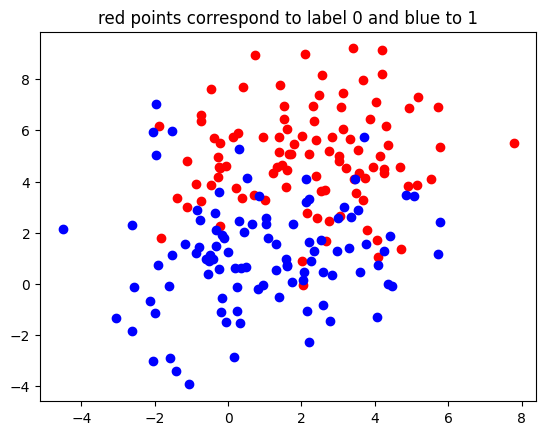

,x,y,label
0,2.101460,8.997861,0.0
1,1.616616,4.440628,0.0
2,7.781410,5.507378,0.0
3,5.537366,4.107650,0.0
4,1.387654,5.154791,0.0


In [484]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import log


mean1 = (2.0 ,5.0)
mean2 = (1.0, 1.0)
num_size = 100 # this is for one gaussian sample, so all together there will be 2*num_size data points

np.random.default_rng(seed=100)
data0 = np.random.multivariate_normal(mean1, np.diag(np.array([4,4])), size=num_size)

np.random.default_rng(seed=100)
data1 = np.random.multivariate_normal(mean2, np.diag(np.array([4,4])), size=num_size)

plt.scatter(data0[:,0], data0[:,1], color='r')
plt.scatter(data1[:,0], data1[:,1], color='b')
plt.title('red points correspond to label 0 and blue to 1')
plt.show()

data = np.vstack((data0, data1))
labels = np.vstack((np.zeros((num_size,1)), np.ones((num_size,1))))


# Put all data into a pandas data frame:
data_df = pd.DataFrame(data, columns = ['x', 'y'])
data_df = pd.concat([data_df, pd.DataFrame(labels, columns=['label'])],axis=1)
data_df.head()



## Plot a separtor (visually) and caculate accuracy

In [457]:

def plot_separator(data, labels, theta):
    assert theta[1] * theta[0] !=0
    
    data_df = pd.DataFrame(data, columns = ['x', 'y'])
    data_df = pd.concat([data_df, pd.DataFrame(labels, columns=['label'])],axis=1)
    
    data1 = np.array(data_df[data_df['label']==1][['x','y']])
    data0 = np.array(data_df[data_df['label']==0][['x','y']])
    
    x_min = min(np.min(data1[:,0]),np.min(data0[:,0]))
    x_max = max(np.max(data1[:,0]),np.max(data0[:,0]))
    y_min = min(np.min(data1[:,1]),np.min(data0[:,1]))
    y_max = max(np.max(data1[:,1]),np.max(data0[:,1]))
    

    if theta[1] == 0:
        y_ref = np.linspace(y_min, y_max, 100)
        x_ref = (theta[2]/theta[0])*np.ones((100,))
    else:
        x_ref = np.linspace(x_min,x_max, 100)
        y_ref = (-theta[2]-theta[0]*x_ref)/theta[1]
        
    plt.scatter(data0[:,0], data0[:,1], color='r')
    plt.scatter(data1[:,0], data1[:,1], color='b')
    plt.plot(x_ref, y_ref, color='g')
    plt.title('red points correspond to label 0 and blue to 1')
    plt.show()
    
# theta = np.array([-1,-1,5])
# plot_separator(data, labels, theta)

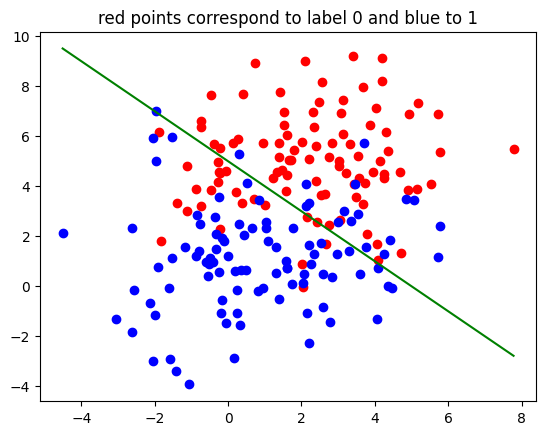

The accuracy of this separtor is 0.795


In [485]:

def eval_separator(data, labels, theta, assign_fn):
    n,d = data.shape
    new_data = np.hstack((data, np.ones((n,1))))
    value = np.vectorize(lambda x: assign_fn(x))(np.matmul(new_data, theta))
    value = value.reshape((value.shape[0],1))
    return (value == labels).sum()/value.shape[0]


def assign_fn(x):
    if x >= 0:
        return 1
    else:
        return 0

guess_theta = np.array([-1,-1,5]) # this is our guess separtator
plot_separator(data, labels, guess_theta)
print('The accuracy of this separtor is {}'.format(eval_separator(data, labels, guess_theta, assign_fn)))


## Cross entropy loss function

In [463]:
from math import log, exp

def sign(x):
    if x >= 0:
        return 1
    else:
        return -1
    
def sigmoid(x):
    return 1/(1 + exp(-x))


def cross_entropy(data, labels, theta, lam):

    n,d = data.shape

    new_data = np.hstack((data,np.ones((n,1))))
    raw_theta = theta[:-1,:]

    guess = np.vectorize(lambda x: sigmoid(x))(np.matmul(new_data, theta))
    
    loss =  -labels * np.log(guess) - (1-labels) * np.log(1 - guess)

    loss = np.array(loss).sum(axis=0, keepdims=True)/n

    reg = lam * np.matmul(raw_theta.T, raw_theta)
 
    return loss + reg


def cross_entropy_grad(data, labels, theta, lam):
    n,d = data.shape

    new_data = np.hstack((data,np.ones((n,1)))) # add one's for the interect
    raw_theta = theta[:-1,:] # theta without theta_0

    guess = np.vectorize(lambda x: sigmoid(x))(np.matmul(new_data, theta))

    grad_theta = np.array((((guess-labels) * data))).sum(axis=0, keepdims=True)/n + 2*lam * raw_theta.T 
    grad_theta_0 = (guess - labels).sum(axis=0, keepdims=True)/n

    
    grad = np.hstack((grad_theta, grad_theta_0))

    return grad


## Hinge Loss  

In [464]:
def change_labels(labels):
    return np.vectorize(lambda x: -1 if x == 0 else x)(labels)
    
    
def hinge_loss(data, labels, theta, lam):

    n,d = data.shape
    new_data = np.hstack((data,np.ones((n,1))))
    
    labels = change_labels(labels)

    guess = np.matmul(new_data, theta)
    raw_theta = theta[:-1,:]
    reg = lam * np.matmul(raw_theta.T, raw_theta)
    
    return np.maximum(0,labels * (1-guess)).sum() + reg


def d_hinge(v):
    d_hinge_f = np.vectorize(lambda v: -1 if v < 1 else 0)
    return d_hinge_f(v)



def hinge_loss_grad(data, labels, theta, lam):

    n,d = data.shape
    new_data = np.hstack((data,np.ones((n,1))))
    labels = change_labels(labels)
    
    a = np.array(d_hinge(labels * (np.matmul(new_data, theta))))

    b = np.array(np.matmul(data.T, np.diag(labels[:,0])).T)

    c = (a*labels).sum(keepdims=True)


    reg = (2*lam*theta[:-1,:]).T
    
    
    return np.hstack(((a * b + reg).sum(axis=0, keepdims=True), c))/n


## Gradient descent

In [465]:
def step_size_fn(i):
    if i<=100:
        return 0.03
    elif i<=300:
        return 0.02
    elif i<=1000:
        return 0.01
    else:
        return 0.001

    
def gd(f, df, x0, step_size_fn, max_iter):
    counter = 0
    
    fs = [float(f(x0))]
    xs = [x0]
    
    while counter <= max_iter:
        counter += 1
        x1 = x0 - step_size_fn(counter) * (df(x0).T)
        x0 = x1
        fs.append(float(f(x0)))
        xs.append(x0)
    return (x0, fs, xs)
 
    
# Test case for gradient descent
    
def f(x):
    return (x+2)**4
def df(x):
    return 4*(x+2)**3

results = gd(f, df, np.array([[2]]), step_size_fn, 3000)
print('Should be around 2 and gradient descent got {}'.format(float(results[0])))

Should be around 2 and gradient descent got -1.9120836825666812


## Apply gradient descent

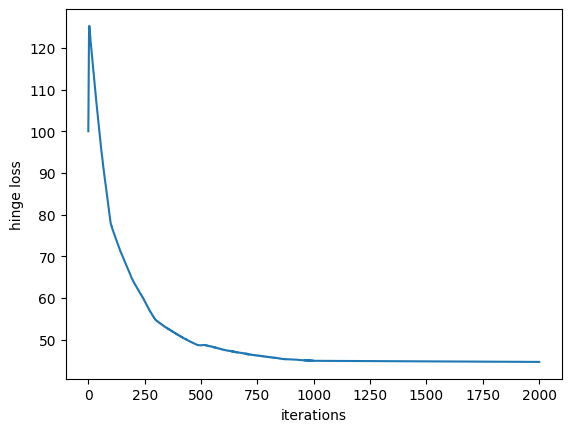

Gradient descent on hinge loss results in fit efficiency:  0.83


In [486]:
n,d = data.shape
theta = np.zeros((d+1,1))
my_lam = 0.2
max_iter = 2000


results = gd(
    lambda x: hinge_loss(data, labels, x, my_lam),
    lambda x: hinge_loss_grad(data, labels, x, my_lam),
    theta, 
    step_size_fn,
    max_iter
)
theta_fit = results[2][-1]
plt.plot(range(len(results[1])),results[1])
plt.xlabel('iterations')
plt.ylabel('hinge loss')
plt.show()

print('Gradient descent on hinge loss results in fit efficiency: ',
      eval_separator(data, labels, theta_fit, assign_fn))

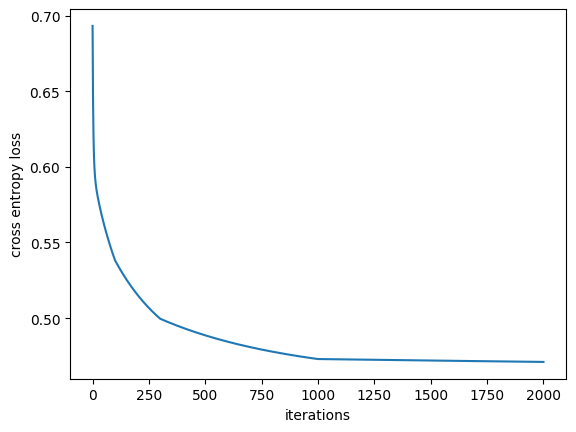

Gradient descent on cross entropy loss results in fit efficiency:  0.855


In [487]:
n,d = data.shape
theta = np.zeros((d+1,1))
my_lam = 0.2
max_iter = 2000

results = gd(
    lambda x: cross_entropy(data, labels, x, my_lam),
    lambda x: cross_entropy_grad(data, labels, x, my_lam),
    theta, 
    step_size_fn,
    max_iter
)
theta_fit = results[2][-1]
plt.plot(range(len(results[1])),results[1])
plt.xlabel('iterations')
plt.ylabel('cross entropy loss')

plt.show()

print('Gradient descent on cross entropy loss results in fit efficiency: ',
      eval_separator(data, labels, theta_fit, lambda x: 1 if sigmoid(x)>=0.5 else 0))

## Cross validation

For both models - the cross entropy one and the hinge loss - we will use cross 10 fold (10 arbitrary) cross validation to see how the classifier performs on the average.


In [471]:
def eval_classifier(
        loss, 
        loss_grad, 
        data_train, 
        labels_train, 
        data_test, 
        labels_test, 
        step_size_fn, 
        assign_fn,
        my_lam, 
        max_iter):
    
    n,d = data_train.shape

    loss_f = lambda x: loss(data_train, labels_train, x, my_lam )
    loss_grad_f = lambda x: loss_grad(data_train, labels_train, x, my_lam)

    theta = gd(loss_f, loss_grad_f, np.zeros((d+1,1)), step_size_fn, max_iter)[0]
    return eval_separator(data_test, labels_test, theta, assign_fn)


def cross_validation(
                    loss, 
                    loss_grad, 
                    data, 
                    labels, 
                    step_size_fn, 
                    assign_fn,
                    my_lam, 
                    max_iter,
                    k=10
                    ):
    
    data_labels = np.hstack((data, labels))
    np.random.shuffle(data_labels) 
    
    results = 0
    
    data_split = np.array_split(data_labels, k, axis=0)
    
    for i in range(k):
        one_out = np.concatenate(data_split[0:i]+data_split[i+1:],axis=0)
        one = data_split[i]
    
        data_train,labels_train = one_out[:,:-1], one_out[:,[-1]]

        data_test,labels_test = one[:,:-1], one[:,[-1]]
        
        efficiency = eval_classifier(
                            loss, 
                            loss_grad, 
                            data_train, 
                            labels_train, 
                            data_test, 
                            labels_test, 
                            step_size_fn, 
                            assign_fn,
                            my_lam, 
                            max_iter
                     )
        
        results += efficiency
        print('{} -th cross validaton gave {}'.format(i+1, efficiency))
    return(results/k)
    


Run 10 fold cross validation for the cross entropy loss function

In [488]:
max_iter = 2000
my_lam = 0.2
k=10

cv = cross_validation(
                    cross_entropy, 
                    cross_entropy_grad, 
                    data, 
                    labels, 
                    step_size_fn, 
                    assign_fn,
                    my_lam, 
                    max_iter,
                    k
                    )

print('The cross validated accuracy is {}'.format(cv))

1 -th cross validaton gave 0.75
2 -th cross validaton gave 0.85
3 -th cross validaton gave 0.7
4 -th cross validaton gave 0.75
5 -th cross validaton gave 0.95
6 -th cross validaton gave 0.9
7 -th cross validaton gave 0.9
8 -th cross validaton gave 1.0
9 -th cross validaton gave 0.9
10 -th cross validaton gave 0.75
The cross validated accuracy is 0.8450000000000001


Run 10 fold cross validation for the hinge loss loss function

In [489]:
max_iter = 2000
my_lam = 0.2
k=10

cv = cross_validation(
                    hinge_loss, 
                    hinge_loss_grad, 
                    data, 
                    labels, 
                    step_size_fn, 
                    assign_fn,
                    my_lam, 
                    max_iter,
                    k
                    )

print('The cross validated accuracy is {}'.format(cv))

1 -th cross validaton gave 0.8
2 -th cross validaton gave 0.9
3 -th cross validaton gave 0.8
4 -th cross validaton gave 0.8
5 -th cross validaton gave 0.7
6 -th cross validaton gave 0.85
7 -th cross validaton gave 0.85
8 -th cross validaton gave 0.85
9 -th cross validaton gave 0.85
10 -th cross validaton gave 0.85
The cross validated accuracy is 0.8249999999999998
